In [1]:
# CHECK THAT SPECTRAL CUBE IS UP-TO-DATE (AT LEAST 0.6.0)
import spectral_cube
print("spectral_cube: "+spectral_cube.__version__)

spectral_cube: 0.6.0


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy import units as u

from spectral_cube import SpectralCube

In [3]:
# SILENCES WARNING ABOUT SPECTRAL CUBE READING IN DATA WITH A STOKES AXIS
import warnings
from spectral_cube.utils import StokesWarning
warnings.filterwarnings(action='ignore', category=StokesWarning, append=True)

In [4]:
# FIGURE MANAGEMENT
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rc("savefig", dpi=100)
plt.rcParams['figure.facecolor']='w'

In [5]:
# READ IN EXAMPLE FITS CUBE: https://almascience.eso.org/dataPortal/member.uid___A001_X1354_X1b8.CB68_sci.spw29.cube.I.pbcor.fits
# WHICH IS PROTOSTELLAR SOURCE IRAS 16544-1604

filename = 'member.uid___A001_X1354_X1b8.CB68_sci.spw29.cube.I.pbcor.fits'
hdu = fits.open(filename)[0]
data = hdu.data
wcs = WCS(hdu.header)
print(wcs)

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 254.3318458333  -16.15664444444  244902480118.0  1.0  
CRPIX : 101.0  101.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -5.555555555556e-05  5.555555555556e-05  122072.1999817  1.0  
NAXIS : 200  200  476  1


In [6]:
# READ IN SPECTRAL CUBE AND CONVERT SPECTRAL AXIS FROM FREQUENCY TO VELOCITY
cube = SpectralCube.read(filename) 
rest_freq = hdu.header['RESTFRQ']
cube_vel = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=rest_freq * u.Hz)
print(cube_vel)

SpectralCube with shape=(476, 200, 200) and unit=Jy / beam:
 n_x:    200  type_x: RA---SIN  unit_x: deg    range:   254.326120 deg:  254.337630 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -16.162200 deg:  -16.151144 deg
 n_s:    476  type_s: VRAD      unit_s: km / s  range:      -30.486 km / s:      40.485 km / s


In [7]:
# CREATE RANGE OF VELOCITIES TO PLOT CHANNELS --> ADJUST AS NEEDED
cube_range = cube_vel.spectral_slab(2.5 * u.km/u.s, +8 * u.km/u.s)
print(cube_range)

SpectralCube with shape=(38, 200, 200) and unit=Jy / beam:
 n_x:    200  type_x: RA---SIN  unit_x: deg    range:   254.326120 deg:  254.337630 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -16.162200 deg:  -16.151144 deg
 n_s:     38  type_s: VRAD      unit_s: km / s  range:        2.534 km / s:       8.063 km / s


In [8]:
# CREATE ARRAY OF VELOCITIES AND ARRAY OF CHANNEL INDICES
velocities = np.array(cube_range.spectral_axis)
tot_channels = cube_range.shape[0]
channels = np.arange(tot_channels)
median = np.int(np.median(channels))

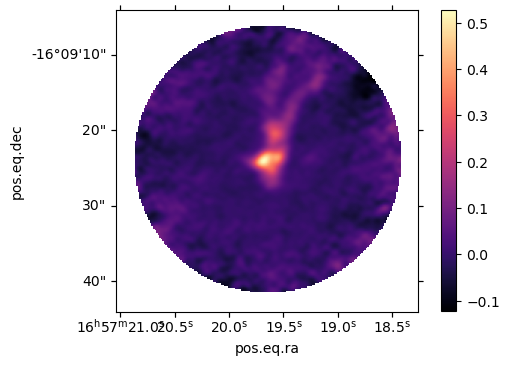

In [9]:
# PLOT SINGLE CHANNEL TO DETERMINE VMIN/VMAX AND ZOOM WINDOW

fig = plt.figure()
ax = plt.subplot(111, projection=wcs, slices=('x', 'y', median, 0))
im = ax.imshow(cube_range[median].value, cmap='magma')
cb = plt.colorbar(im) 
plt.show()

In [10]:
# DEFINE VMIN/VMAX AND COORDINATES TO ZOOM IN ON OUTFLOW REGION

vmin = -0.1
vmax = 0.5

start_RA = '16h 57m 20.2s'
start_Dec = '-16d 09m 30s'
end_RA = '16h 57m 18.8s'
end_Dec = '-16d 09m 07s'

wcs_2d = wcs.dropaxis(-1)
start_x, start_y = skycoord_to_pixel(SkyCoord(start_RA, start_Dec, frame='icrs'), wcs_2d, 1, 'wcs')
end_x, end_y = skycoord_to_pixel(SkyCoord(end_RA, end_Dec, frame='icrs'), wcs_2d, 1, 'wcs')

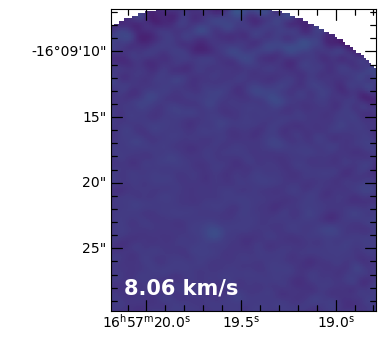

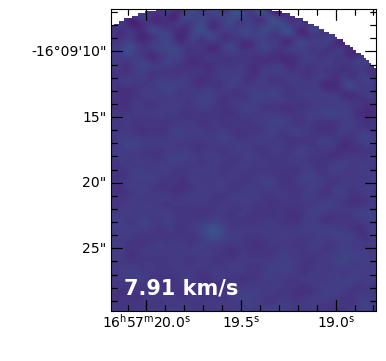

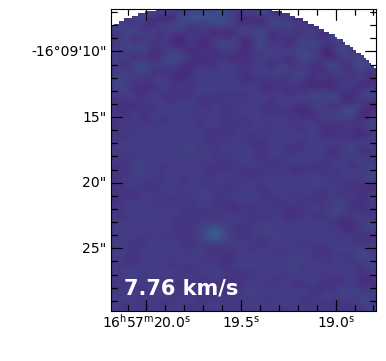

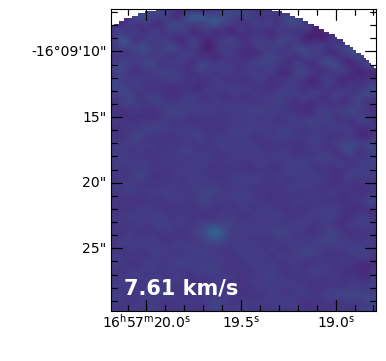

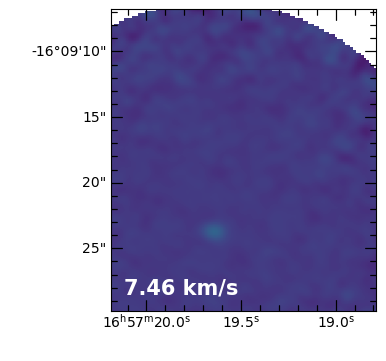

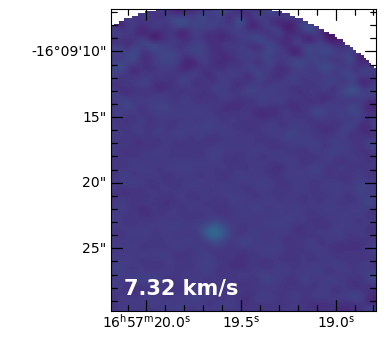

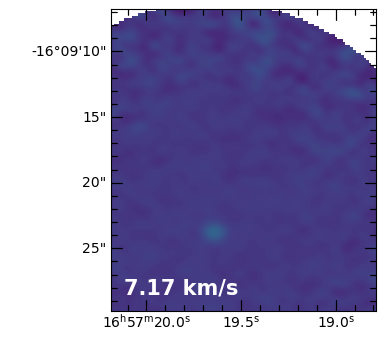

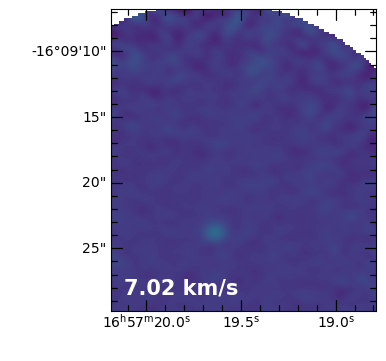

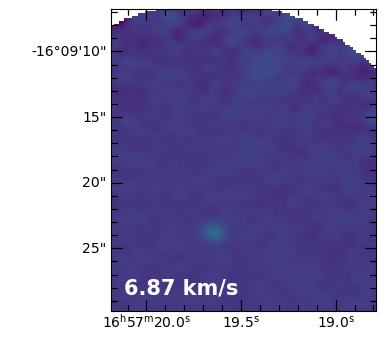

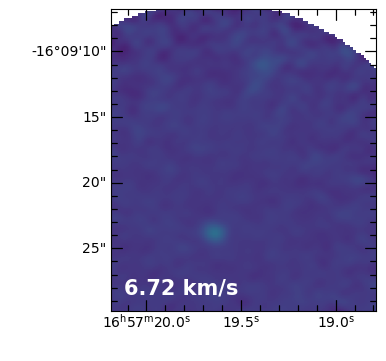

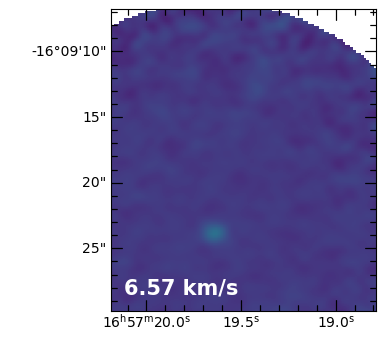

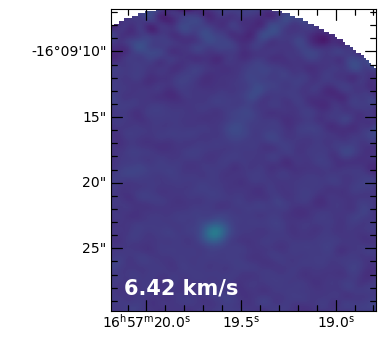

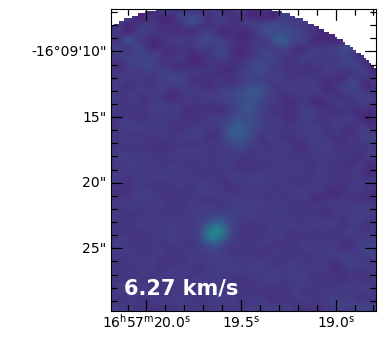

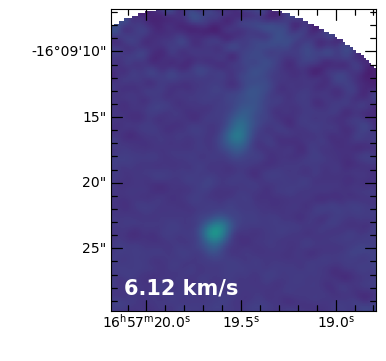

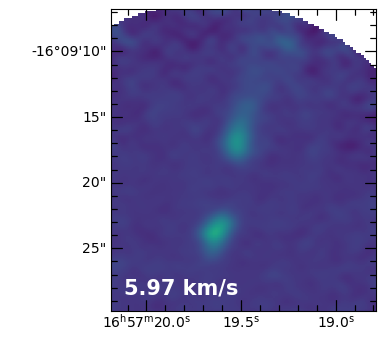

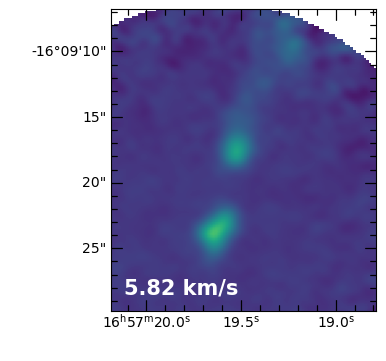

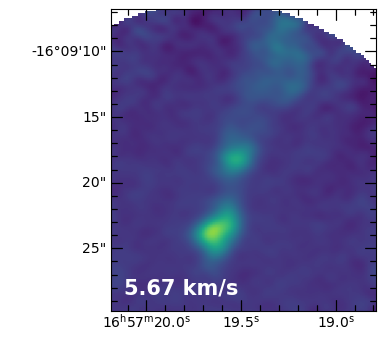

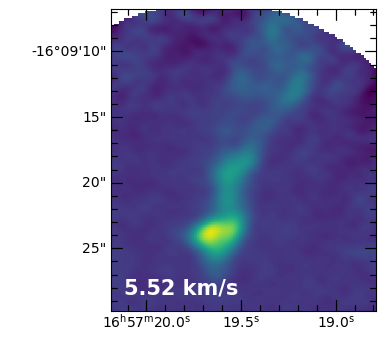

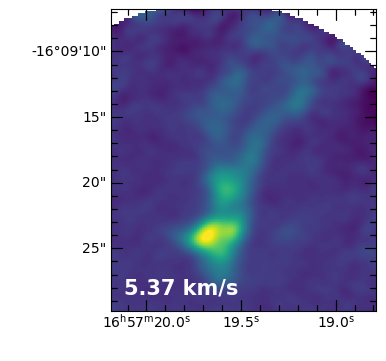

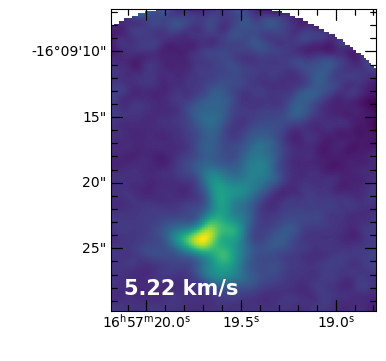

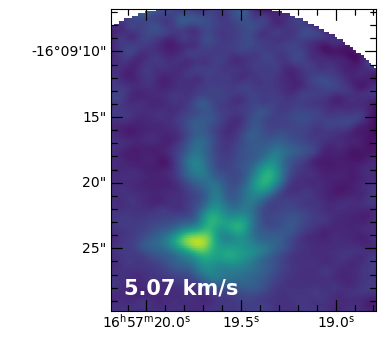

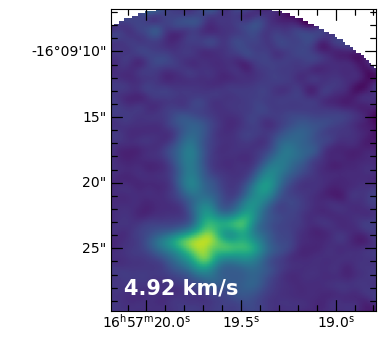

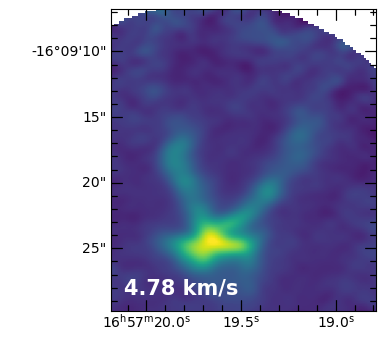

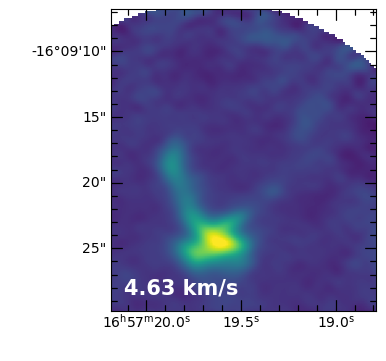

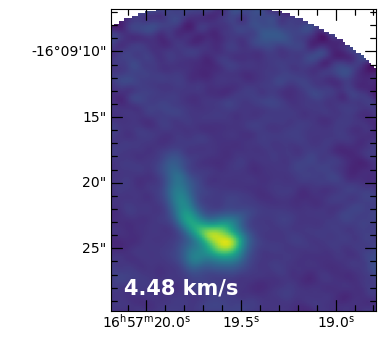

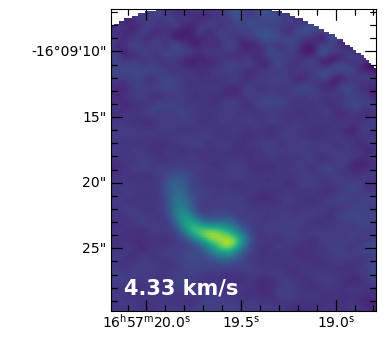

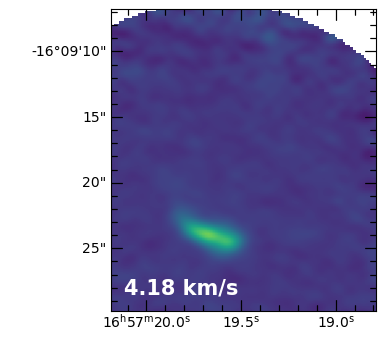

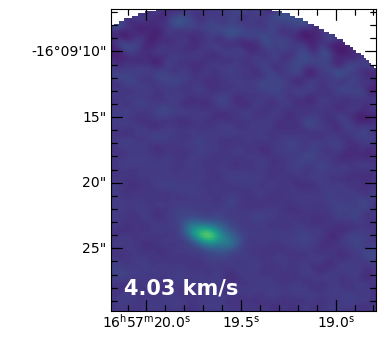

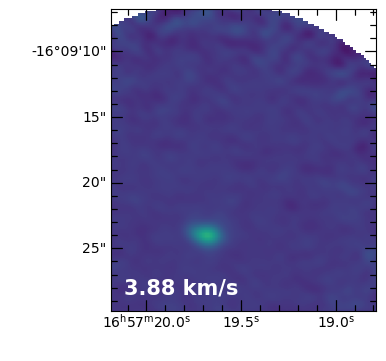

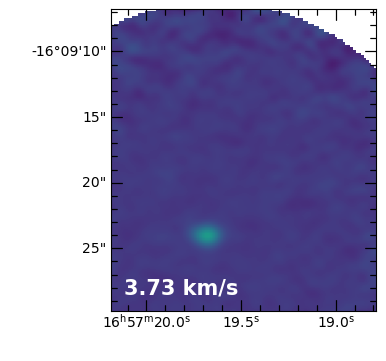

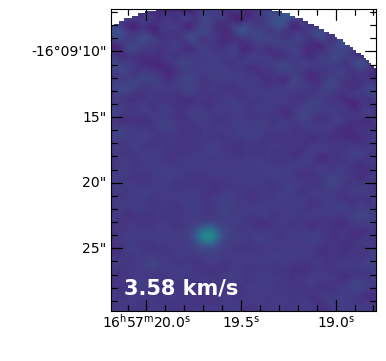

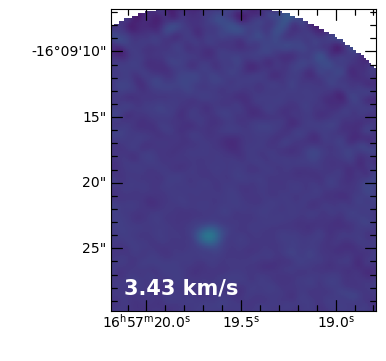

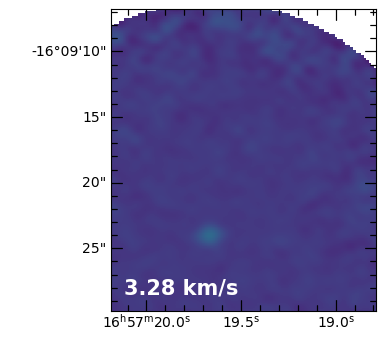

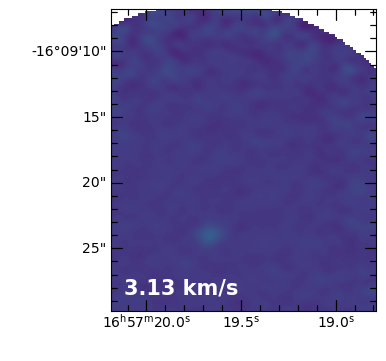

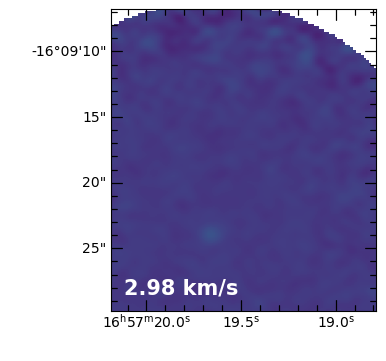

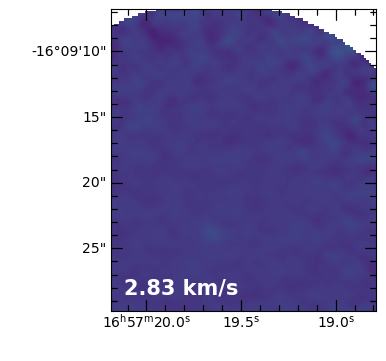

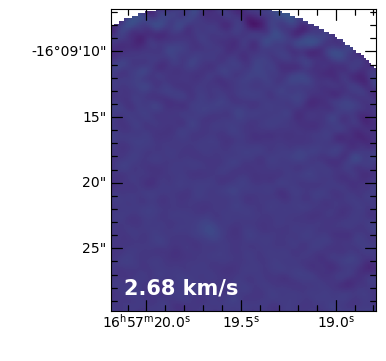

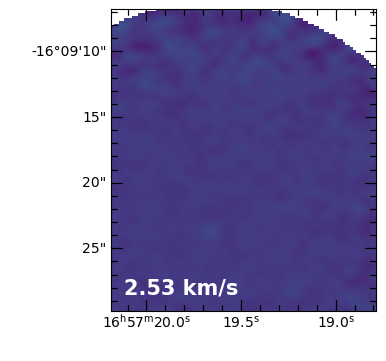

In [11]:
# PLOT INDIVIDUAL CHANNEL FIGURES --> EXPERIMENT WITH TICK_PARAMS TO CUSTOMIZE

for channel,velocity in zip(channels,velocities):
    fig = plt.figure()
    ax = plt.subplot(111, projection=wcs, slices=('x', 'y', channel, 0))
    im = ax.imshow(cube_range[channel].value, cmap='viridis', vmin=vmin, vmax=vmax)
        
    ax0 = ax.coords[0]
    ax0.set_ticks(number=3)
    ax0.display_minor_ticks(True)
    ax.set_xlabel(' ')
    
    ax1 = ax.coords[1]
    ax1.set_ticks(number=5)
    ax1.display_minor_ticks(True)
    ax.set_ylabel(' ')
    
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(axis='both', which='both', direction='in', colors='k')
#     ax.tick_params(axis='x', labelbottom=False)
#     ax.tick_params(axis='y', labelleft=False)
    
    #zoom window fitted to data
    plt.xlim(start_x,end_x)
    plt.ylim(start_y,end_y)
    plt.text(start_x+5,start_y+5, "%.2f"%round(velocity,2)+' km/s', ha='left', va='bottom', fontsize=15, fontweight='bold', c='white')
    plt.show()

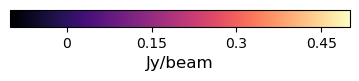

In [12]:
# GENERATE STANDALONE COLORBAR
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="magma", vmin=vmin, vmax=vmax)
plt.gca().set_visible(False)
cbar = plt.colorbar(orientation='horizontal', format='%g') 
cbar.locator = ticker.MaxNLocator(5)
cbar.update_ticks()
cbar.set_label('Jy/beam', fontsize=12)